<a href="https://colab.research.google.com/github/Roozbeh96/CSCI-5525-Advanced-ML/blob/Temp/Finalproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [70]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [72]:
train.drop(['id'], axis = 1, inplace = True)

In [73]:
train.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


In [74]:
train['text'].apply(lambda x:len(str(x).split())).max()

861

In [75]:
train.describe()

,text,author
count,19579,19579
unique,19579,3
top,"This process, however, afforded me no means of...",EAP
freq,1,7900


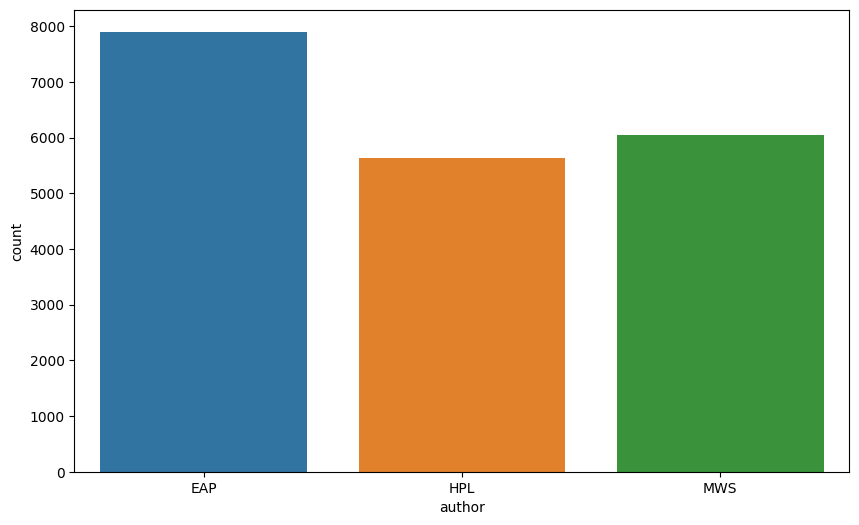

In [76]:
plt.figure(figsize=(10,6))
sns.countplot(x='author',hue='author', data = train)
plt.show()

In [77]:
from plotly import graph_objs as go
temp = train.groupby('author').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,author,text
0,EAP,7900
2,MWS,6044
1,HPL,5635


In [78]:
fig = go.Figure(go.Funnelarea(
    text =temp.author,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Authors Distribution"}
    ))
fig.show()

In [79]:
from wordcloud import WordCloud, STOPWORDS

In [80]:
# Join all text together and space them with '' which is space to count for word cloud
text_data = ''.join(train['text'].dropna())


wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    stopwords=STOPWORDS,
    max_words=200
).generate(text_data)



In [81]:
text_data_LOP = 'LOP'.join(train['text'].dropna())
print(text_data_LOP[0:250])

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.LOPIt never once oc


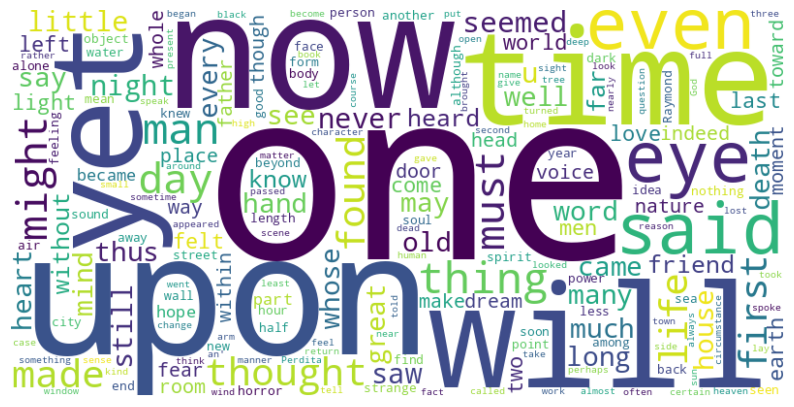

In [82]:
# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

In [83]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU,SimpleRNN
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping

In [84]:
from sklearn.preprocessing import LabelEncoder

In [85]:
X_train, X_val, Y_train, Y_val = train_test_split(train.text.values,
                                                    train.author.values,
                                                    stratify = train.author.values,
                                                    test_size = 0.2,
                                                    random_state = 37)
Y_train = pd.Series(Y_train)
Y_val = pd.Series(Y_val)

le = LabelEncoder()

# For different authors, the label would be 0,1,2
Y_train = le.fit_transform(Y_train)
Y_val = le.fit_transform(Y_val)
# Change the label for each author to one hot vector[0]->[1,0,0],[1]->[0,1,0],[2]->[0,0,1]
Y_train = to_categorical(Y_train, num_classes=3)
Y_val = to_categorical(Y_val, num_classes=3)

In [86]:
# Make a dictionary based on the input dataset. Give label to each unique word.
# "The"->12, "Good"->53, "Car"->254, "is"->30, ...
token = text.Tokenizer(num_words=None)
max_len = 1500

token.fit_on_texts(list(X_train) + list(X_val))

# Change the input dataset to the sequence of numbers
# "The car is good"->[12,254,30,53]
X_train_seq = token.texts_to_sequences(X_train)
X_val_seq = token.texts_to_sequences(X_val)

#zero pad the sequences
# maxlen = 10->[12,254,30,53,0,0,0,0,0,0]
X_train_pad = sequence.pad_sequences(X_train_seq, maxlen=max_len)
X_val_pad = sequence.pad_sequences(X_val_seq, maxlen=max_len)

word_index = token.word_index

In [87]:
# Number of unique words in the whole dataset
len(word_index)

25943

In [88]:
print(X_train_seq[:1])
print(len(X_train_seq[:1][0]))
print(X_train[:1])

[[19, 13, 4556, 10, 356, 2268, 3, 14, 37, 207, 2, 1872, 5924, 4, 5, 1126, 16050, 1127, 7, 5925, 2545, 24, 38, 12278, 5, 2945, 3, 169, 1, 3695, 1730, 10108, 10109, 10110, 2195, 2032, 10111]]
37
['But he requested my attention particularly, and with an air of mysterious sagacity, to a thick octavo, written in barbarous Latin by one Hedelin, a Frenchman, and having the quaint title, "Duelli Lex Scripta, et non; aliterque."']


In [89]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [90]:
num_classes = 3  # For the 3 authors in the dataset

with strategy.scope():
    # Create the SimpleRNN model
    model_RNN = Sequential()
    # Via embedding, each word would be in word_index would be vector in space with 300 variables.
    # "Good"->53->[0.2, -0.1, -0.65, ...., 0.001] with length of 300.
    # These numbers are learnable. Each input can have the size of max_len by 300 in which is number of
    # words in a statement (can be padded with zeros) with 300 features.
    model_RNN.add(Embedding(input_dim=len(word_index) + 1,
                        output_dim=300,
                        input_length=max_len))
    # the input to the SimpleRNN layer is a 3D tensor of shape:(batch_size, max_len = 1500, 300)
    # At each time step, the size of the x_t is (batch_size,300) which is all the t^{th} words in the batch.
    # The SimpleRNN computes the hidden state h_t based on x_t and the previous hidden state h_{t-1}
    # h_t=tanh(x_t*W_x+h_{t-1}*W_h+b)->h_t: (batch_size, 100) Activation function is tanh(applied element-wise).
    # x_t: (batch_size,300)
    # W_x: (300,100)
    # W_h: (100,100)
    # b: (100,1)
    # For calculating the loss function, only h_t is used which is afftected by all the h_{t-1}s
    model_RNN.add(SimpleRNN(100))
    model_RNN.add(Dense(num_classes, activation='softmax'))  # 3 neurons for 3 classes

    # Compile the model with categorical cross-entropy
    model_RNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model_RNN.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning:

Argument `input_length` is deprecated. Just remove it.



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_RNN.fit(X_train_pad, Y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.5044 - loss: 0.9762
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 623s 2s/step - accuracy: 0.9114 - loss: 0.2500
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 568s 2s/step - accuracy: 0.9883 - loss: 0.0451
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9976 - loss: 0.0136
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 566s 2s/step - accuracy: 0.9994 - loss: 0.0033


In [95]:
model_RNN.load_weights('spooky_author_simpleRNN.weights.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning:

Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 



In [ ]:
model_RNN.save_weights('spooky_author_simpleRNN.weights.h5')

In [93]:
from sklearn.metrics import roc_auc_score

def roc_auc(predictions, target):
    '''
    This function returns the AUC Score for multi-class predictions and labels.
    '''
    # Ensure the target is one-hot encoded
    if len(target.shape) == 1:
        target = to_categorical(target, num_classes=predictions.shape[1])

    # Compute the ROC AUC score for multi-class
    return roc_auc_score(target, predictions, multi_class='ovr')

In [96]:
scores = model_RNN.predict(X_val_pad)
print("Auc: %.2f%%" % (roc_auc(scores,Y_val)))

123/123 ━━━━━━━━━━━━━━━━━━━━ 43s 344ms/step
Auc: 0.93%


In [100]:
with strategy.scope():

    # A simple LSTM with glove embeddings and one dense layer
    model_LSTM = Sequential()
    # model.add(Embedding(len(word_index) + 1,
    #                  300,
    #                  weights=[embedding_matrix],
    #                  input_length=max_len,
    #                  trainable=False))
    model_LSTM.add(Embedding(input_dim=len(word_index) + 1,
                    output_dim=300,
                    input_length=max_len))
    # LSTM architecture at each time step(for each word)
    # Forget gate:f_t=\sigmoid(x_t*W_f+h_{t-1}*U_f+b_f) This is named "Forgot gate" because it decides how much information from
    # C_{t-1} should be preserved and pass to C_{t}
    # Input gate:i_t=\sigmoid(x_t*W_i+h_{t-1}*U_i+b_i)
    # Candidate Cell gate:\tild{C}_t = tanh(x_t*W_c+h_{t-1}*U_c+b_c)
    # Cell gate:C_t = C_t = f_t*C_{t-1} + i_t*\tild{C}_t
    # Output gate: O_t = \sigmoid(x_t*W_o+h_{t-1}*U_o+b_o)
    # Hidden state: h_t = O_t * tanh(C_t)
    # The "dropout = 0.3" hyperparameter specifies randomly how much of the input dataset x_t turns to be zero.
    # x_t =[0.2, -0.1, -0.65, 0.92, ..., 0.001]-> x_t =[0.0, -0.1, 0.0, 0.92, ..., 0.001]
    # 30 percent of the vector turns to zero.
    # it helps prevent the LSTM from becoming too reliant on specific inputs at each time step.
    # The "recurrent_dropout = 0.3" hyperparameter specifies randomly how much of the hidden state h_{t-1} turns to be zero.
    # it Prevents overfitting by reducing dependency on specific hidden states.
    # To implement it, we use Dropout Masks = [0,0,1,...,1,1] for each of them separately. Dropout_Masks_x_t~=Dropout_Masks_h_{t-1}
    # At the end, we just use h_t of the last LSTM unit, and pass it to dense layer for the classification purpose.
    # For tasks like for machine translation and sumerization (seq2seq model), C_t is also utilized.
    # For Attention models, all hidden states (h_1,h_2,...,h_t) are incorporated.
    model_LSTM.add(LSTM(100, dropout=0.3, recurrent_dropout=0.3))
    model_LSTM.add(Dense(num_classes, activation='softmax'))
    model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

model_LSTM.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_LSTM.fit(X_train_pad, Y_train, epochs=5, batch_size=64*strategy.num_replicas_in_sync)

Epoch 1/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 1369s 6s/step - accuracy: 0.5563 - loss: 0.9086
Epoch 2/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 1445s 6s/step - accuracy: 0.8874 - loss: 0.3045
Epoch 3/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 1235s 5s/step - accuracy: 0.9507 - loss: 0.1436
Epoch 4/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 1229s 5s/step - accuracy: 0.9667 - loss: 0.0989
Epoch 5/5
245/245 ━━━━━━━━━━━━━━━━━━━━ 1201s 5s/step - accuracy: 0.9768 - loss: 0.0659


In [ ]:
model_LSTM.load_weights('spooky_author_LSTM.weights.h5')

In [ ]:
model_LSTM.save_weights('spooky_author_LSTM.weights.h5')

In [ ]:
scores = model_LSTM.predict(X_val_pad)
print("Auc: %.2f%%" % (roc_auc(scores,Y_val)))

123/123 ━━━━━━━━━━━━━━━━━━━━ 100s 808ms/step
Auc: 0.48%


In [102]:
pip install torch-adopt

In [103]:
from adopt import ADOPT
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [104]:
Y_train_indices = np.argmax(Y_train, axis=1)
Y_val_indices = np.argmax(Y_val, axis=1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_pad, dtype=torch.long)
X_val_tensor = torch.tensor(X_val_pad, dtype=torch.long)
Y_train_tensor = torch.tensor(Y_train_indices, dtype=torch.long)
Y_val_tensor = torch.tensor(Y_val_indices, dtype=torch.long)

In [105]:
class TextDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [107]:
batch_size = 32

train_dataset = TextDataset(X_train_tensor, Y_train_tensor)
val_dataset = TextDataset(X_val_tensor, Y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



In [108]:
# Verify the DataLoader
for inputs, labels in train_loader:
    print(inputs.shape)  # Should be (batch_size, max_len)
    print(labels.shape)  # Should be (batch_size,)
    break

torch.Size([32, 1500])
torch.Size([32])


In [110]:
# Define the LSTM model class
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, max_len, pretrained_embeddings=None, freeze_embeddings=False):
        super(LSTMClassifier, self).__init__()

        # Embedding layer (with optional pretrained embeddings)
        if pretrained_embeddings is not None:
            self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=freeze_embeddings)
        else:
            self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM layer with dropout and recurrent dropout
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            batch_first=True,
                            dropout=0.3)  # Applies dropout between LSTM layers (when num_layers > 1)

        # Dense layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)

        # Softmax activation(We do not use it since nn.CrossEntropy does have sofmax layer in itself)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # x shape: (batch_size, max_len)
        x = self.embedding(x)  # Shape: (batch_size, max_len, embedding_dim)

        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x)  # h_n shape: (1, batch_size, hidden_dim)

        # Use the last hidden state for classification
        final_hidden_state = h_n[-1]  # Shape: (batch_size, hidden_dim)

        # Dense layer and softmax activation
        out = self.fc(final_hidden_state)  # Shape: (batch_size, num_classes)

        return out

# Model hyperparameters
vocab_size = len(word_index) + 1  # Vocabulary size
embedding_dim = 300               # Embedding dimension
hidden_dim = 100                  # LSTM hidden units
num_classes = 3                   # Number of output classes
max_len = 1500                    # Maximum sequence length

# Initialize the model
model_LSTM_ADOPT = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, num_classes, max_len)

# Print the model summary
print(model_LSTM_ADOPT)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizeradop = ADOPT(model_LSTM_ADOPT.parameters(), lr=1e-3)
optimizeradam = torch.optim.Adam(model_LSTM_ADOPT.parameters(), lr=1e-3)


LSTMClassifier(
  (embedding): Embedding(25944, 300)
  (lstm): LSTM(300, 100, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=100, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1



In [ ]:
num_epochs = 1

# Assuming you have DataLoader for training data
for epoch in range(num_epochs):
    model_LSTM_ADOPT.train()
    for batch in train_loader:  # Assuming train_loader provides (inputs, labels)
        inputs, labels = batch
        optimizeradop.zero_grad()  # Reset gradients
        outputs = model_LSTM_ADOPT(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizeradop.step()  # Update weights

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
num_epochs = 2  # Example: Run for 3 epochs

# Assuming you have DataLoader for training data
for epoch in range(num_epochs):
    model_LSTM_ADOPT.train()
    total_loss = 0  # Track total loss for the epoch

    # Loop through batches with an enumeration to track batch number
    for batch_idx, (inputs, labels) in enumerate(train_loader, start=1):
        optimizeradop.zero_grad()           # Reset gradients
        outputs = model_LSTM_ADOPT(inputs)  # Forward pass
        loss = criterion(outputs, labels)   # Compute loss

        loss.backward()                     # Backpropagation
        optimizeradop.step()                # Update weights

        total_loss += loss.item()           # Accumulate loss

        # Print epoch and batch number along with the loss
        print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Completed, Average Loss: {avg_loss:.4f}\n")

Epoch [1/2], Batch [1/490], Loss: 1.0881
Epoch [1/2], Batch [2/490], Loss: 1.1355
Epoch [1/2], Batch [3/490], Loss: 1.0679
Epoch [1/2], Batch [4/490], Loss: 1.1065
Epoch [1/2], Batch [5/490], Loss: 1.0956
Epoch [1/2], Batch [6/490], Loss: 1.1280
Epoch [1/2], Batch [7/490], Loss: 1.1041
Epoch [1/2], Batch [8/490], Loss: 1.0985
Epoch [1/2], Batch [9/490], Loss: 1.1122
Epoch [1/2], Batch [10/490], Loss: 1.0814
Epoch [1/2], Batch [11/490], Loss: 1.0642
Epoch [1/2], Batch [12/490], Loss: 1.1017
Epoch [1/2], Batch [13/490], Loss: 1.1049
Epoch [1/2], Batch [14/490], Loss: 1.0267
Epoch [1/2], Batch [15/490], Loss: 1.0808
Epoch [1/2], Batch [16/490], Loss: 1.0580
Epoch [1/2], Batch [17/490], Loss: 1.1040
Epoch [1/2], Batch [18/490], Loss: 1.0837
Epoch [1/2], Batch [19/490], Loss: 1.0537
Epoch [1/2], Batch [20/490], Loss: 1.0967
Epoch [1/2], Batch [21/490], Loss: 1.0916
Epoch [1/2], Batch [22/490], Loss: 1.1043
Epoch [1/2], Batch [23/490], Loss: 1.0557
Epoch [1/2], Batch [24/490], Loss: 1.0735
E

In [ ]:
torch.save(model_LSTM_ADOPT.state_dict(), 'model_LSTM_ADOPT.pth')

In [ ]:
model_LSTM_ADOPT.load_state_dict(torch.load('model_LSTM_ADOPT.pth'))

In [ ]:
model_LSTM_ADOPT.eval()

In [ ]:
# Track correct predictions and total samples
correct = 0
total = 0

# No need to compute gradients during evaluation
with torch.no_grad():
    for inputs, labels in val_loader:  # Assuming val_loader is your DataLoader for validation data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model_LSTM_ADOPT(inputs)  # Outputs are raw logits

        # Get predicted class (highest logit)
        _, predicted = torch.max(outputs, 1)  # Returns (values, indices)

        # Update total and correct counts
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate and print accuracy
accuracy = 100 * correct / total
print(f'Accuracy on the validation dataset: {accuracy:.2f}%')